In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/'

osp = MAC

## 1. Load aligned peaksets

In [17]:
output_dir = osp+'/pymz/mzmine/peak_picked_files/samples_alignment/'

In [18]:
all_df = pd.read_csv(output_dir+'pp_aligned.csv', index_col=0)
feature_description = all_df.iloc[:,:2]
all_samples = all_df.iloc[:,2:-1]
all_samples.columns = [x.split(" ")[0] for x in list(all_samples.columns)]

## 2. Label samples

In [22]:
sample_description = pd.read_csv(osp+'sample_description.csv', index_col=0)

In [29]:
all_samples = all_samples[sample_description.index]

,Condition,Dataset,ConditionDataset
Sample Name,,,
KM_10.mzXML,control,Malaria,controlMalaria
KM_9.mzXML,infected,Malaria,infectedMalaria
KM_3.mzXML,infected,Malaria,infectedMalaria
KM_4.mzXML,control,Malaria,controlMalaria
KM_1.mzXML,control,Malaria,controlMalaria
...,...,...,...
ZIK9.mzXML,infected,Zika,infectedZika
ZIK8.mzXML,infected,Zika,infectedZika
ZIK3.mzXML,infected,Zika,infectedZika


## 3. Log transformation

In [33]:
all_samples_log = np.log2(all_samples+1)
print('Total number of peaksets: {}'.format(len(all_samples_log)))

Total number of peaksets: 37220


KeyboardInterrupt: 

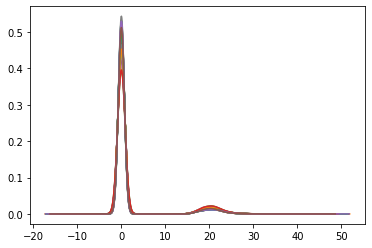

In [8]:
all_samples_log.plot.density(legend = False)

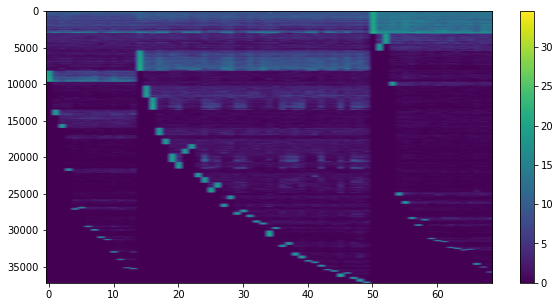

In [34]:
plt.figure(figsize=(10,5))
plt.imshow(all_samples_log,aspect='auto')
plt.colorbar()
plt.show()

## 4. PCA plot

In [35]:
# rearranging the dataframe
Zik = all_samples_log.transpose()[np.array(sample_description['Dataset'] == 'Zika')].transpose()
zik_con = Zik.transpose()[np.array(sample_description[sample_description["Dataset"] == "Zika"]['Condition'] =="control")].transpose()
zik_inf = Zik.transpose()[np.array(sample_description[sample_description["Dataset"] == "Zika"]['Condition'] =="infected")].transpose()
Mal = all_samples_log.transpose()[np.array(sample_description['Dataset'] == 'Malaria')].transpose()
mal_con = Mal.transpose()[np.array(sample_description[sample_description["Dataset"] == "Malaria"]['Condition'] =="control")].transpose()
mal_inf = Mal.transpose()[np.array(sample_description[sample_description["Dataset"] == "Malaria"]['Condition'] =="infected")].transpose()
vl = all_samples_log.transpose()[np.array(sample_description['Dataset'] == 'VL')].transpose()
vl_con = vl.transpose()[np.array(sample_description[sample_description["Dataset"] == "VL"]['Condition'] =="control")].transpose()
vl_inf = vl.transpose()[np.array(sample_description[sample_description["Dataset"] == "VL"]['Condition'] =="infected")].transpose()

In [36]:
pdList = [vl_con,zik_con,mal_con, vl_inf,zik_inf, mal_inf]  
all_samples_log_rearanged = pd.concat(pdList, axis = 1)

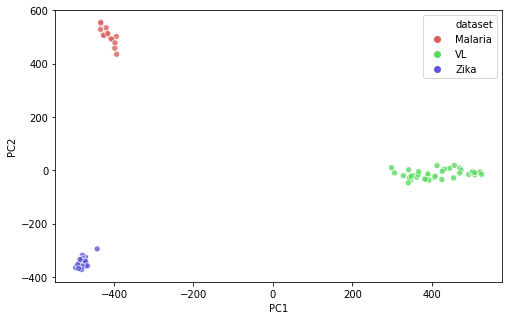

In [37]:
from sklearn.decomposition import PCA
pca_samples = PCA(n_components=3)

principalComponents = pca_samples.fit_transform(all_samples_log.transpose())
principalComponents_df = pd.DataFrame(data = principalComponents, columns= ['PC1','PC2', 'PC3'])
principalComponents_df['condition'] = list(sample_description['Condition'])
principalComponents_df['dataset'] = list(sample_description['Dataset'])

plt.figure(figsize=(8,5))
sns.scatterplot(x="PC1", y="PC2",hue="dataset",
    palette=sns.color_palette("hls", 3),
    data=principalComponents_df,
    legend="full",
    alpha=0.8
)

## 5. Filtering

In [38]:
from metab_utils import get_ids_for_top_percent
idzik = get_ids_for_top_percent(Zik, 50)
idmal = get_ids_for_top_percent(Mal, 50)
idvl = get_ids_for_top_percent(vl, 50)
inters = set(idzik) & set(idmal) & set(idvl)
print('Total number of peaksets remaining after filtering: {}'.format(len(inters)))

Total number of peaksets remaining after filtering: 625


In [39]:
all_samples_log_filtered = all_samples_log.loc[list(inters)]

In [40]:
all_samples_filtered = all_samples.loc[list(inters)]
all_samples_filtered.to_csv('/Users/anamaria/Desktop/samples_filtered.csv')

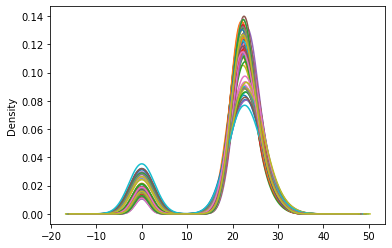

In [41]:
all_samples_log_filtered.plot.density(legend=False)

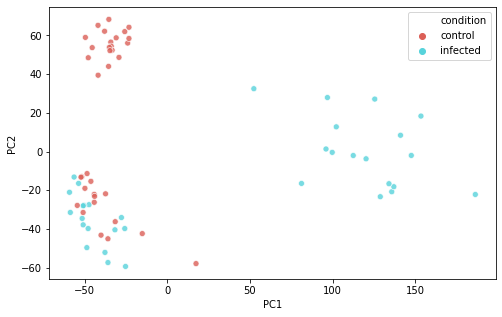

In [42]:
pca_samples = PCA(n_components=3)

principalComponents = pca_samples.fit_transform(all_samples_log_filtered.transpose())
principalComponents_df = pd.DataFrame(data = principalComponents, columns= ['PC1','PC2', 'PC3'])
principalComponents_df['condition'] = list(sample_description['Condition'])
principalComponents_df['dataset'] = list(sample_description['Dataset'])

plt.figure(figsize=(8,5))
sns.scatterplot(x="PC1", y="PC2",hue="condition",
    palette=sns.color_palette("hls", 2),
    data=principalComponents_df,
    legend="full",
    alpha=0.8
)

In [99]:
filtered_samples_log_description = all_samples_log_filtered_filled.transpose()

In [101]:
filtered_samples_log_description['Condition'] = ''
filtered_samples_log_description['Dataset'] = ''
filtered_samples_log_description['ConditionDataset'] = ''


filtered_samples_log_description['Condition'] = sample_description['Condition']
filtered_samples_log_description['Dataset'] = sample_description['Dataset']
filtered_samples_log_description['ConditionDataset'] = sample_description['ConditionDataset']
    

In [102]:
filtered_samples_log_description.to_csv(osp+'/pymz/filtered_samples_log_filled_description.csv', header=True, index=True, sep=',', mode='w')

## 6. Imputing missing values with KNN (skip this step now)

In [93]:
all_samples_log_filtered_na = all_samples_log_filtered.copy()
all_samples_log_filtered_na.replace(0, np.nan, inplace = True)

In [90]:
sys.path.append('..')
from metab_utils import impute_knn


In [94]:
sample_values = all_samples_log_filtered_na

In [96]:
zik_con_filled = impute_knn(sample_values, list(zik_con.columns))
zik_inf_filled = impute_knn(sample_values, list(zik_inf.columns))
vl_con_filled = impute_knn(sample_values, list(vl_con.columns))
vl_inf_filled = impute_knn(sample_values, list(vl_inf.columns))
mal_con_filled = impute_knn(sample_values, list(mal_con.columns))
mal_inf_filled = impute_knn(sample_values, list(mal_inf.columns))

Imputing row 1/625 with 0 missing, elapsed time: 0.092
Imputing row 101/625 with 0 missing, elapsed time: 0.096
Imputing row 201/625 with 1 missing, elapsed time: 0.098
Imputing row 301/625 with 2 missing, elapsed time: 0.100
Imputing row 401/625 with 0 missing, elapsed time: 0.102
Imputing row 501/625 with 3 missing, elapsed time: 0.104
Imputing row 601/625 with 0 missing, elapsed time: 0.106
Imputing row 1/625 with 0 missing, elapsed time: 0.082
Imputing row 101/625 with 0 missing, elapsed time: 0.083
Imputing row 201/625 with 0 missing, elapsed time: 0.086
Imputing row 301/625 with 3 missing, elapsed time: 0.088
Imputing row 401/625 with 0 missing, elapsed time: 0.090
Imputing row 501/625 with 2 missing, elapsed time: 0.092
Imputing row 601/625 with 0 missing, elapsed time: 0.096
Imputing row 1/625 with 0 missing, elapsed time: 0.095
Imputing row 101/625 with 0 missing, elapsed time: 0.103
Imputing row 201/625 with 0 missing, elapsed time: 0.109
Imputing row 301/625 with 1 missing, 

In [97]:
pdList = [vl_inf_filled,vl_con_filled,zik_inf_filled, zik_con_filled, mal_inf_filled,mal_con_filled]  
all_samples_log_filtered_filled = pd.concat(pdList, axis = 1)
all_samples_log_filtered_filled = all_samples_log_filtered_filled[list(all_samples_log.columns)]

## 7. Limma analysis in R

In [51]:
output_dir = osp+'/pymz/mzmine/'
sample_description_file = output_dir + 'sample_description.csv'
all_samples_log_filtered_file = output_dir + 'all_samples_log.csv'


sample_description.to_csv(sample_description_file, header=True, index=True, sep=',', mode='w')
all_samples_log_filtered.to_csv(all_samples_log_filtered_file, header=True, index=True, sep=',', mode='w')

In [45]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [48]:
%%R

library(limma)
library(Biobase)

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from ‘package:limma’:

    plotMA


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, 

In [46]:
file_to_be_analysed = all_samples_log_filtered_file

In [52]:
%%R -i file_to_be_analysed -i sample_description_file


eset = readExpressionSet(file_to_be_analysed, sample_description_file, 
                         exprsArgs=list(sep=",", header=TRUE,quote="",row.names = 1),
                         phenoDataArgs=list(sep=",", header=TRUE,quote=""))

edata = exprs(eset)
pheno = pData(eset)

#creating the levels for the Condition and Dataset in pData
levels(pheno$Condition) = c('control','infected')
levels(pheno$Dataset)  = c('Malaria', 'VL', 'Zika')
pData(eset) = pheno

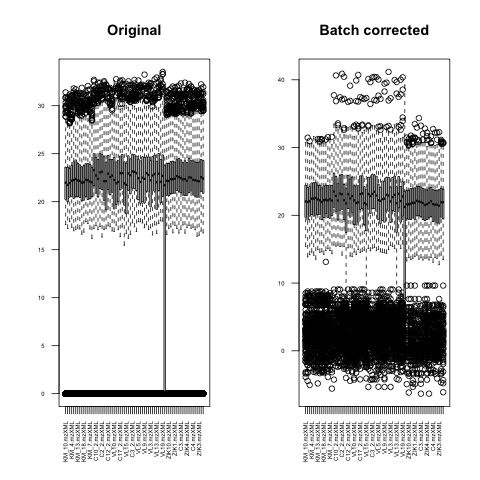

In [53]:
%%R -o edata2

eset.dataset = factor(as.character(pData(eset)$Dataset))
eset.condition = factor(as.character(pData(eset)$Condition))

batch = pheno$Dataset
edata2 = removeBatchEffect(edata, batch, design = model.matrix(~eset.condition))
par(mfrow=c(1,2), cex.axis=0.5, las=2)
boxplot(as.data.frame(edata),main="Original")
boxplot(as.data.frame(edata2),main="Batch corrected")
write.table(edata2, file = "/Users/anamaria/Desktop/batchremoved.csv", sep = ",", quote = FALSE)

In [54]:
limma_table_file = output_dir + 'limma_independent_toptable.csv'

In [55]:
%%R -i limma_table_file

eset.dataset = factor(as.character(pData(eset)$Dataset))
eset.condition = factor(as.character(pData(eset)$Condition))

eset.design = model.matrix(~ 0 + eset.condition + eset.dataset)
eset.fit = lmFit(eset, eset.design)


#define the contrasts you want to make, estimate the coefficients 
#and std errs for these contrasts, eBayes moderation of std errs.
contr = makeContrasts(eset.conditioninfected - eset.conditioncontrol, levels=colnames(coef(eset.fit)))
eset.fit = contrasts.fit(eset.fit, contr)
eset.fit = eBayes(eset.fit)

#Extract results per metabolite
top.table = topTable(eset.fit, sort.by="p", n=Inf)
write.csv(top.table, file = limma_table_file, sep = ",", quote = FALSE)

In [60]:
limma_table = pd.read_csv(limma_table_file, sep=',')
limma_table.index = limma_table[limma_table.columns[0]]
del limma_table[(limma_table.columns[0])]

In [61]:
print("The number of significantly different metabolites is:",len(limma_table[limma_table['adj.P.Val'] < 0.05]))

The number of significantly different metabolites is: 207


In [63]:
#Prepare .csv for mummichog
data = feature_description.loc[limma_table.index]
data['adj-p'] = limma_table['adj.P.Val']
data['t-val'] = limma_table['t']
data['logFC'] = limma_table['']
data['custom_id'] = list(data.index)
data.to_csv(output_dir+'limma_independent_toptable_features.csv', header=True, index=None, sep='\t', mode='w')
#needs to be with \t instead of , , for mummichog to work

## 8. Create peakinfolist made up of peakinfo objects

In [119]:
sys.path.append('..')
import peakinfo
peakinfolist=[]
for row_id, row in feature_description.iterrows():
    peak = peakinfo.PeakInfo(row_id, row['row m/z'], row['row retention time'])
    peakinfolist.append(peak)

In [120]:
from peakinfo import get_peak_by_cid
for row_id, row in limma_table.iterrows():
    peak = get_peak_by_cid(peakinfolist, row_id)
    peak.add_pval(row['P.Value'])
    peak.add_tval(row['t'])
    peak.add_logfc(row['logFC'])

In [121]:
import pickle
with open(osp+'pymz/mzmine/peak_picked_files/peakinfolist.dict', 'wb') as handle:
    pickle.dump(peakinfolist, handle)

## 9. Covid data

In [161]:
data = pd.read_csv(osp+'covid19_data/compound_data.csv')
sample_description = pd.read_csv(osp+'covid19_data/compound_design.csv', index_col = 0)

data.index = np.array(data['Identifier'])
del data['Identifier']
data.fillna(0,inplace=True)
data_log = np.log2(data+1)

In [166]:
output_dir = osp+'/covid19_data/'
sample_description_file = output_dir + 'sample_description.csv'
data_log_file = output_dir + 'data_log.csv'


sample_description.to_csv(sample_description_file, header=True, index=True, sep=',', mode='w')
data_log.to_csv(all_samples_log_filtered_file, header=True, index=True, sep=',', mode='w')

In [167]:
%%R

library(limma)
library(Biobase)

In [ ]:
%%R -i data_log_file -i sample_description_file


eset = readExpressionSet(file_to_be_analysed, sample_description_file, 
                         exprsArgs=list(sep=",", header=TRUE,quote=""),
                         phenoDataArgs=list(sep=",", header=TRUE,quote=""))

edata = exprs(eset)
pheno = pData(eset)

#creating the levels for the Condition and Dataset in pData
levels(pheno$group) = c('healthy','nonCOVID19', 'nonsevere', 'severe')

pData(eset) = pheno

In [ ]:
limma_table_file = osp+'/covid19_data/limma_independent_healthy_severe.csv'

In [145]:
%%R -i limma_table_file

eset.group = factor(as.character(pData(eset)$group))

eset.design = model.matrix(~ 0 + eset.group)
eset.fit = lmFit(eset, eset.design)


#define the contrasts you want to make, estimate the coefficients 
#and std errs for these contrasts, eBayes moderation of std errs.
contr = makeContrasts(eset.groupsevere - eset.grouphealthy, levels=colnames(coef(eset.fit)))
eset.fit = contrasts.fit(eset.fit, contr)
eset.fit = eBayes(eset.fit)

#Extract results per metabolite
top.table = topTable(eset.fit, sort.by="p", n=Inf)
write.csv(top.table, file = limma_table_file, sep = ",", quote = FALSE)

In [146]:
data_log

,h_jkdz1,h_jkdz2,h_jkdz3,h_jkdz4,h_jkdz5,h_jkdz6,h_jkdz7,h_jkdz8,h_jkdz9,h_jkdz10,...,s_ZX12,s_ZX13,s_ZX14,s_ZX15,s_ZX16,s_ZX17,s_ZX18,s_ZX19,s_ZX20,s_ZX21
Identifier,,,,,,,,,,,,,,,,,,,,,
C21482,24.210524,22.605535,23.216722,22.344858,24.252105,21.771680,22.977033,22.945814,23.894727,23.857913,...,20.860867,21.621323,19.492901,21.426086,21.666702,21.612682,20.483626,21.406291,21.014045,21.058747
C18218,21.370881,20.971685,20.463232,20.959265,21.274690,21.331122,21.124241,20.912063,20.942654,21.127447,...,20.426978,20.430644,21.618107,20.611561,20.329786,21.482624,20.155726,21.490707,20.434726,20.491468
C05127,16.420754,0.000000,16.495419,0.000000,17.285808,0.000000,0.000000,0.000000,16.466464,16.889556,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.077231,0.000000,0.000000
C01152,25.810118,25.800437,25.726539,25.428610,25.707397,25.232153,24.832617,26.008753,25.475693,26.442297,...,24.780223,24.915409,24.597624,24.979283,25.222766,24.540413,24.628327,25.934691,25.260903,25.547599
C02918,0.000000,17.470054,17.773398,17.296169,18.290507,19.452934,18.318133,18.970235,18.060966,0.000000,...,18.348302,0.000000,18.729714,15.108287,0.000000,19.322959,19.673094,21.943916,18.115210,16.298897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C07880,20.752001,17.530614,17.332919,20.261283,19.395695,19.032759,20.043788,16.785012,19.272531,18.866342,...,22.036309,18.733412,0.000000,17.851992,22.994616,21.202083,20.219033,18.814398,21.806713,17.918811
C00141,29.551342,29.324517,29.581627,29.227362,29.679986,29.424745,29.674879,29.631262,29.803893,29.772273,...,28.354619,29.297082,29.072965,28.651508,28.872962,28.958423,27.804448,28.830787,28.982194,28.337097
C00262,23.471758,23.543435,23.240474,23.660159,23.835118,22.544475,24.120246,23.302091,24.146419,23.646399,...,24.154257,24.097960,23.480978,23.472386,23.832386,23.768046,23.234045,24.893491,24.039979,23.480130


In [147]:
sample_description

,sample,group
0,h_jkdz1,healthy
1,h_jkdz2,healthy
2,h_jkdz3,healthy
3,h_jkdz4,healthy
4,h_jkdz5,healthy
...,...,...
91,s_ZX17,severe
92,s_ZX18,severe
93,s_ZX19,severe
94,s_ZX20,severe
